In [ ]:
!pip install crcmod
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

!gsutil -m -o 'GSUtil:parallel_composite_upload_threshold_1M''GSUtil:sliced_object_download_max_components=8' cp -r gs://evenergy163.appspot.com/data/** .

Copying gs://evenergy163.appspot.com/data/HS861 2010-.xlsx...
Copying gs://evenergy163.appspot.com/data/California Electric Rates.csv...
Copying gs://evenergy163.appspot.com/data/annual_generation_state.xlsx...
Copying gs://evenergy163.appspot.com/data/HS861M 2010-.xlsx...
Copying gs://evenergy163.appspot.com/data/evwatts.public.connector.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.dictionary.txt...
Copying gs://evenergy163.appspot.com/data/Monthly Gas Prices.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicles.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.evse.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.session.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehiclesessions.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicletrips.csv...
Copying gs://evenergy163.appspot.com/data/generation_monthly.xlsx...
Copying gs://evenergy163.appspot.com/data/iea.png...


In [ ]:
session_data = pd.read_csv('evwatts.public.session.csv')
evse_data = pd.read_csv('evwatts.public.evse.csv')
#merging session data with evse data
merged_data = pd.merge(session_data, evse_data[['evse_id', 'charge_level', 'region', 'metro_area']], on='evse_id', how='left')
session_data = merged_data

session_data['start_datetime'] = pd.to_datetime(session_data['start_datetime'])
session_data['year_month'] = session_data['start_datetime'].dt.to_period('M').dt.to_timestamp()
session_data.head(5)

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,charge_level,region,metro_area,year_month
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,L2,Middle Atlantic,Undesignated,2020-03-01
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,L2,Middle Atlantic,Undesignated,2020-03-01
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,L2,Middle Atlantic,"Rochester, NY Metro Area",2020-03-01
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2020-03-01
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2020-02-01


In [ ]:
pacific_data = session_data[session_data['region'] == 'Pacific']
monthly_pacific = pacific_data.groupby('year_month')['session_id'].count().reset_index()
energy_pacific = pacific_data.groupby('year_month')['energy_kwh'].sum().reset_index()

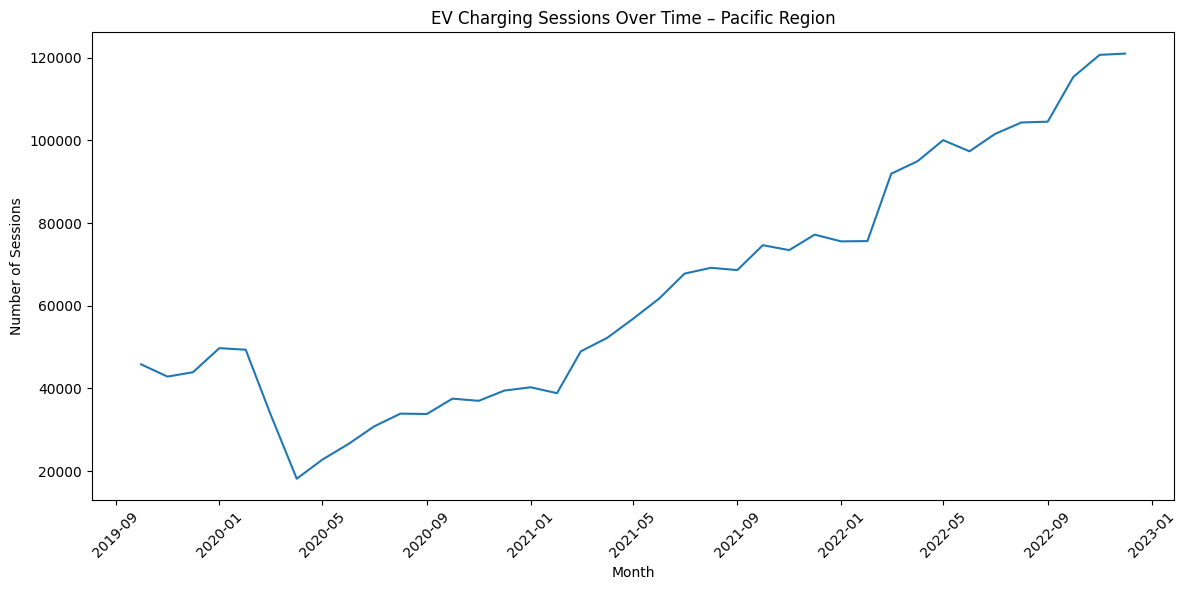

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_pacific, x='year_month', y='session_id')
plt.title('EV Charging Sessions Over Time – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


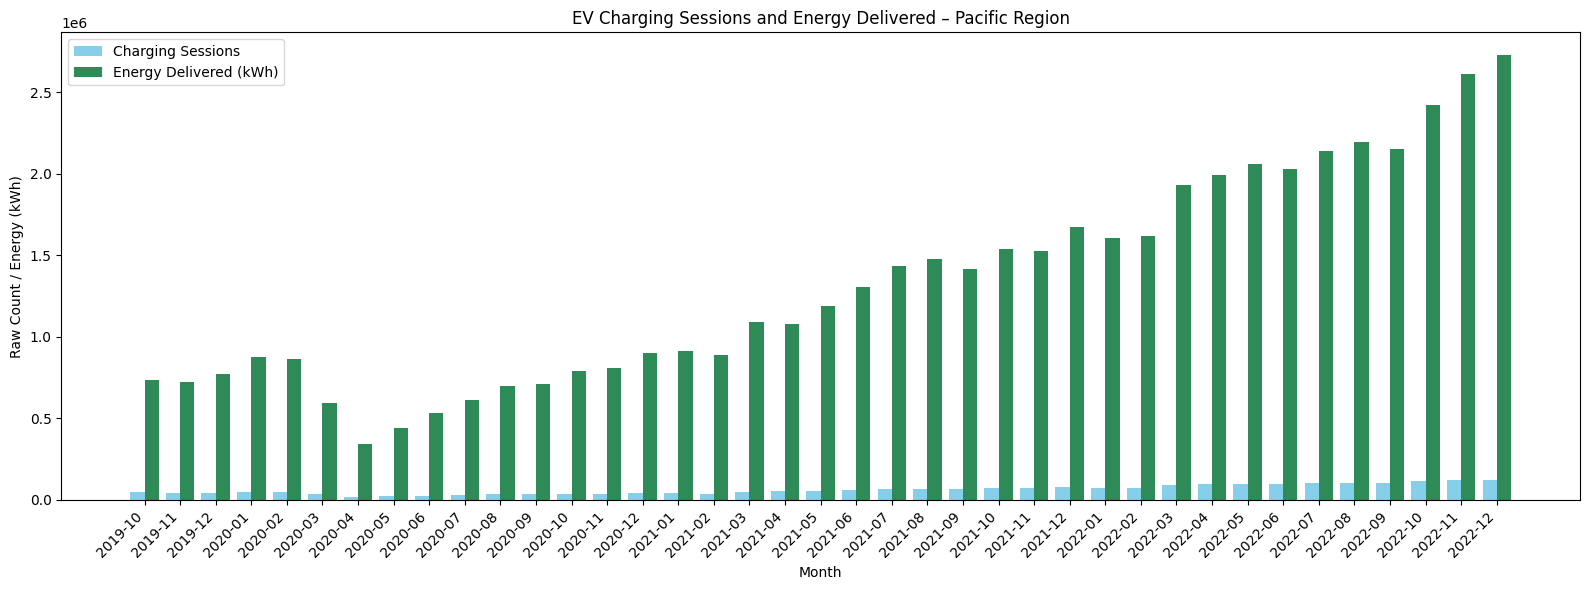

In [ ]:
bar_df = monthly_pacific.merge(energy_pacific, on='year_month')
bar_df.columns = ['year_month', 'Sessions', 'Energy']

# Set up bar plot
x = range(len(bar_df))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], bar_df['Sessions'], width=width, label='Charging Sessions', color='skyblue')
plt.bar([i + width/2 for i in x], bar_df['Energy'], width=width, label='Energy Delivered (kWh)', color='seagreen')

# X-axis labels
plt.xticks(x, bar_df['year_month'].dt.strftime('%Y-%m'), rotation=45, ha='right')

plt.title('EV Charging Sessions and Energy Delivered – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Raw Count / Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

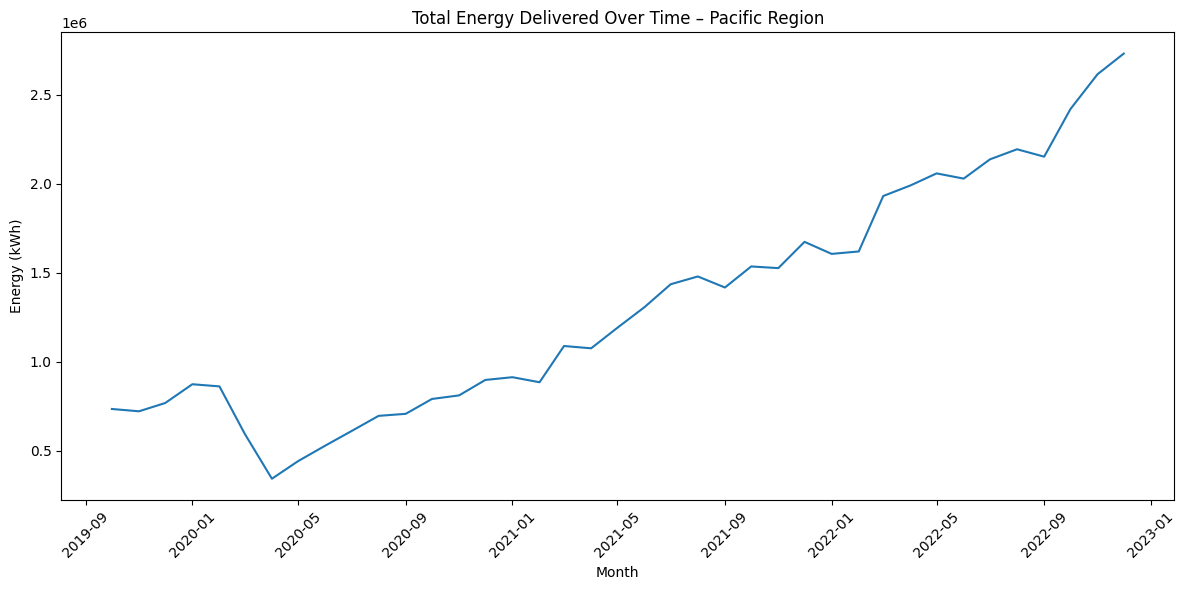

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=energy_pacific, x='year_month', y='energy_kwh')
plt.title('Total Energy Delivered Over Time – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


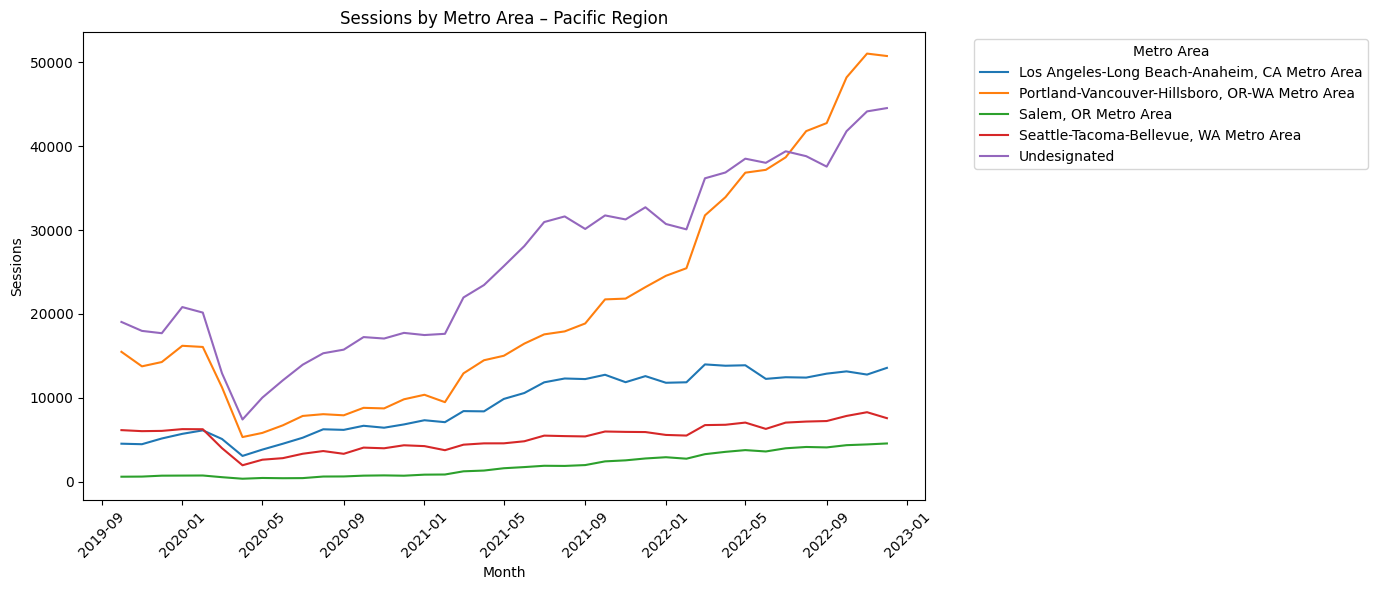

In [ ]:
top_metros_pacific = pacific_data['metro_area'].value_counts().head(5).index.tolist()

metro_monthly_pacific = pacific_data[pacific_data['metro_area'].isin(top_metros_pacific)] \
    .groupby(['year_month', 'metro_area'])['session_id'].count().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=metro_monthly_pacific, x='year_month', y='session_id', hue='metro_area')
plt.title('Sessions by Metro Area – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Sessions')
plt.xticks(rotation=45)
plt.legend(title='Metro Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


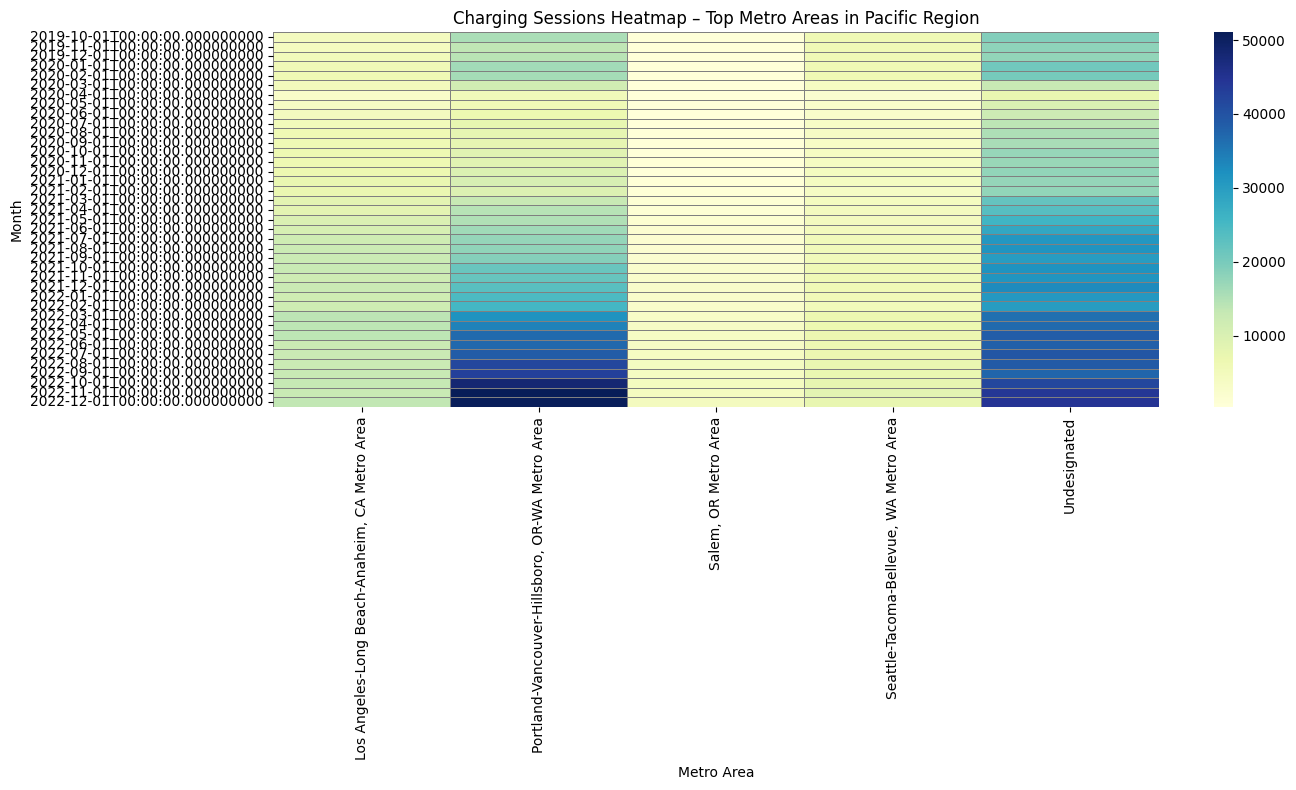

In [ ]:
top_metros = pacific_data['metro_area'].value_counts().head(10).index.tolist()
heatmap_data = pacific_data[pacific_data['metro_area'].isin(top_metros)]

# Pivot table: rows = month, columns = metro area, values = session count
pivot = heatmap_data.groupby(['year_month', 'metro_area'])['session_id'].count().reset_index()
heatmap_table = pivot.pivot(index='year_month', columns='metro_area', values='session_id').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_table, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Charging Sessions Heatmap – Top Metro Areas in Pacific Region')
plt.xlabel('Metro Area')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

Pre-Forecasting Diagnostic Checklist

24+ months = better for seasonality & forecasting

In [ ]:
pacific_monthly = session_data[session_data['region'] == 'Pacific'] \
    .groupby('year_month')['session_id'].count().reset_index()

num_months = pacific_monthly.shape[0]
print(f"Number of months: {num_months}")


Number of months: 39


Stationarity check

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(pacific_monthly['session_id'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: 0.9530370938534437
p-value: 0.9937448701435689


data is not stationary.

Visual Trend check

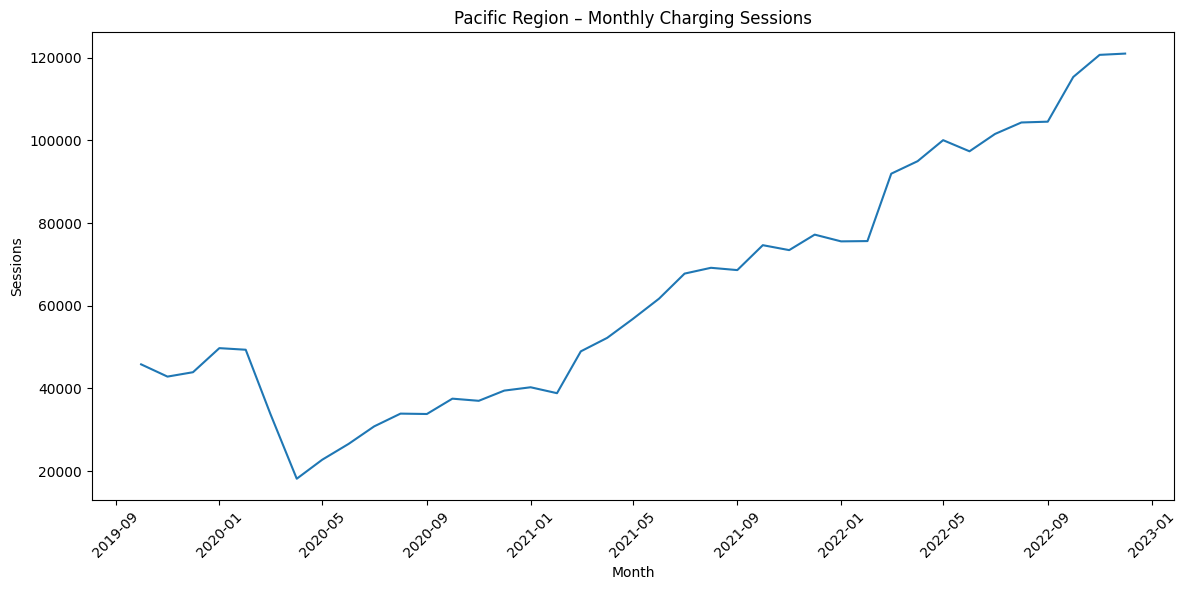

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=pacific_monthly, x='year_month', y='session_id')
plt.title('Pacific Region – Monthly Charging Sessions')
plt.xlabel('Month')
plt.ylabel('Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Prediction


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu3v95p77/r279bo0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu3v95p77/c8e_jit9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27733', 'data', 'file=/tmp/tmpu3v95p77/r279bo0v.json', 'init=/tmp/tmpu3v95p77/c8e_jit9.json', 'output', 'file=/tmp/tmpu3v95p77/prophet_modelxj8gbhmz/prophet_model-20250423051319.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:13:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:13:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


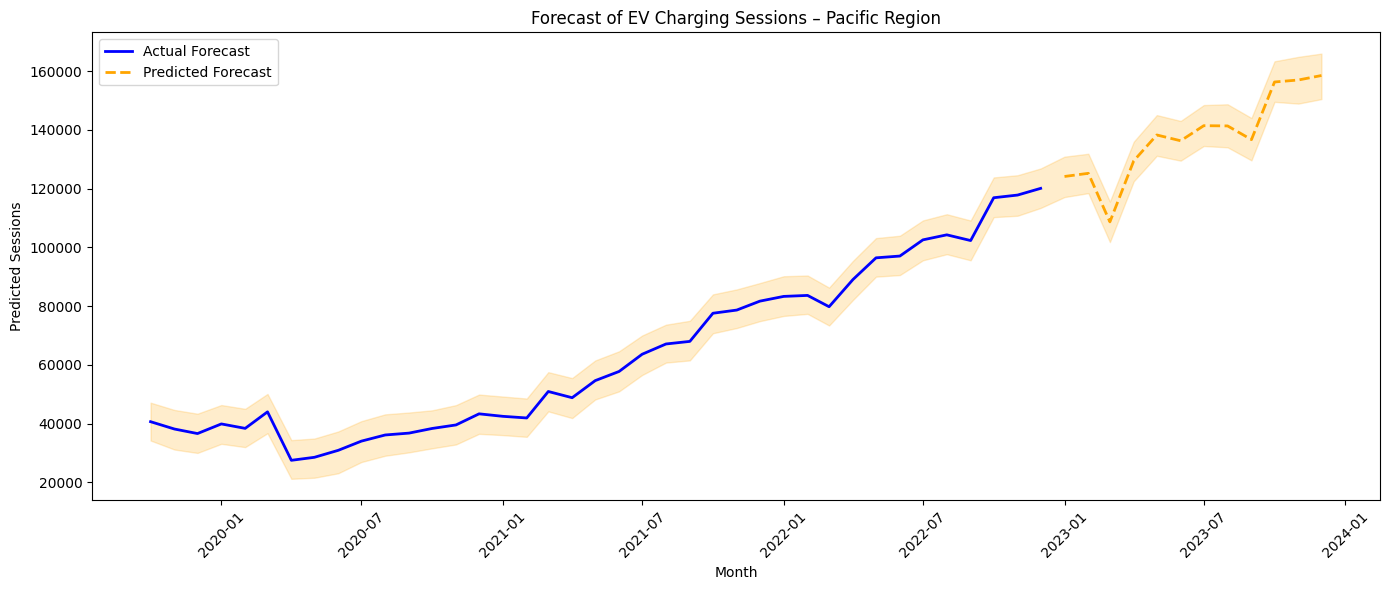

In [ ]:
from prophet import Prophet

# Step 1: Prepare data
pacific_data = session_data[session_data['region'] == 'Pacific'].copy()
pacific_data['start_datetime'] = pd.to_datetime(pacific_data['start_datetime'])
pacific_data['year_month'] = pacific_data['start_datetime'].dt.to_period('M').dt.to_timestamp()

# Step 2: Aggregate sessions per month
monthly_sessions = pacific_data.groupby('year_month')['session_id'].count().reset_index()
monthly_sessions.columns = ['ds', 'y']

# Step 3: Fit Prophet model
model = Prophet()
model.fit(monthly_sessions)

# Step 4: Make future dataframe and forecast
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Step 5: Merge forecast with historical data
forecast['is_forecast'] = forecast['ds'] > monthly_sessions['ds'].max()

# Step 6: Plot
plt.figure(figsize=(14, 6))

# Actual (historical)
sns.lineplot(data=forecast[~forecast['is_forecast']], x='ds', y='yhat', label='Actual Forecast', color='blue', linewidth=2)

# Forecast (future)
sns.lineplot(data=forecast[forecast['is_forecast']], x='ds', y='yhat', label='Predicted Forecast', color='orange', linestyle='--', linewidth=2)

# Optional: Plot uncertainty interval (optional, can be removed for clarity)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='orange')

# Plot settings
plt.title('Forecast of EV Charging Sessions – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Predicted Sessions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The number of charging sessions has been steadily increasing since late 2019.

There's a clear upward trend, especially strong from 2021 onward.

A dip is visible around early 2020 (likely pandemic-related), then strong recovery.

Forecast (Blue Line & Shaded Area):
The blue line shows the predicted number of sessions per month for ~12 months into the future.

The shaded region represents the uncertainty interval (95% CI), showing the model’s confidence.

Forecast predicts growth to continue, reaching over 160,000 sessions per month by end of 2023.

Model Behavior:
The model captured the trend very well.

It allows for flexible seasonality and adjusts to changes in momentum.

Confidence bands are reasonably tight, indicating a stable forecast.

Using Facebook Prophet, we forecast EV charging sessions in the Pacific region to continue increasing through 2023.